# Visualise metrics and results

Load saved dicts containing metrics (puffs and waves IoUs, sparks precision and recall) and visualize them in order to understan the behaviour of the network.

Dicts are saved in folders `training_validation\<training name>\<metrics type>`, where "metrics type" can be
- `puff_wave_ious`
- `spark_prec_rec`
- `separated_events`
- ... (work in progress)

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import glob
import os
import imageio
from collections import defaultdict
import pprint
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Set training params

- UNet has been trained for 100K epochs (how to justify this in manuscript?) using focal loss, where `alpha = class_weights` and `gamma = 5`, and `batch_size = 1`.
- Average background has been subtracted from whole videos (tried "moving average" but didn't improve results: what is the best approach?).
- Chunks have `duration = 256` and `step = 32`, 6 frames are ignored by loss in each chunk. Each chunk is normalised to have values between 0 and 1.
- The only preprocessing is a 2d Gaussian smoothing.
- Tried to train network using temporal reduction but it didn't improve the results.

In [4]:
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6 # first and last 6 frames not used for computing metrics

In [5]:
metrics_folder = os.path.join("trainings_validation", training_name)

# Jaccard index (IoU score) for puffs and waves
- Using exclusion radius (erosion & dilation applied to annotations)
- Considering varying minimal size of events and detection threshold
- Removing holes from puffs, where sparks have a higher probability
- Tried computing IoU score for joined puffs and waves, but does not help

## Puffs and waves IoU score
- UNet's output processing:
    - threshold is applied to output
    - if required, remove holes with 5 iterations of dilation and erosion
    - remove small object with size < 2 * min_radius * n_dims (can be changed)
    - empty marginal frames (not used by loss function)
- Jaccad index computation:
    - compute inclusion and union of binary annotations and preds
    - if required, compute dilation and erosion of annotations according to exclusion radius
    - compute intersection of annotations and preds with ignore_mask (regions of the input that were ignored during training)
    - compute intersection over union
    - if union is empty, iou is set to 1

In [6]:
data_folder = os.path.join(metrics_folder, "puff_wave_ious")

In [7]:
# Load dicts

# dict containing all iou scores for all puffs for all movies
with open(os.path.join(data_folder, "ious_puffs.json"), 'r') as f:
    ious_puffs = json.load(f) # t x min_r x exclusion_r x video_id
    
# dict containing all iou scores for all puffs averaged over all movies
with open(os.path.join(data_folder, "ious_puffs_average.json"), 'r') as f:
    ious_puffs_average = json.load(f) # t x min_r x exclusion_r
    
# dict containing all iou scores for all puffs without holes for all movies
with open(os.path.join(data_folder, "ious_puffs_no_holes.json"), 'r') as f:
    ious_puffs_no_holes = json.load(f) # t x min_r x video_id
    
# dict containing all iou scores for all puffs without holes averaged over all movies
with open(os.path.join(data_folder, "ious_puffs_no_holes_average.json"), 'r') as f:
    ious_puffs_no_holes_average = json.load(f) # t x min_r
    
# dict containing all iou scores for all waves for all movies
with open(os.path.join(data_folder, "ious_waves.json"), 'r') as f:
    ious_waves = json.load(f) # t x min_r x exclusion_r x video_id
    
# dict containing all iou scores for all waves averaged over all movies
with open(os.path.join(data_folder, "ious_waves_average.json"), 'r') as f:
    ious_waves_average = json.load(f) # t x min_r x exclusion_r

### Get confusion matrix for varying detection threshold and min size (exclusion radius set to 0)

#### Considering average over all movies.

In [8]:
# fix exclusion radius to zero
exclusion_r = '0'

# get dicts for fixed exclusion radius
dict_cmatrix_puffs = {t: {r: iou[exclusion_r] for (r, iou) in iou_min_r.items()} for (t, iou_min_r) in ious_puffs_average.items()}
dict_cmatrix_waves = {t: {r: iou[exclusion_r] for (r, iou) in iou_min_r.items()} for (t, iou_min_r) in ious_waves_average.items()}

# for puffs without holes, metrics has been computed only for exclusion_r = 0

# get dataframes
df_puffs = pd.DataFrame.from_dict(dict_cmatrix_puffs)
df_puffs_no_holes = pd.DataFrame.from_dict(ious_puffs_no_holes_average)
df_waves = pd.DataFrame.from_dict(dict_cmatrix_waves)

#### Get confusion matrix for sample movie

In [24]:
movie_id = '34'

# fix exclusion radius to zero
exclusion_r = '0'

# get dicts for sample movie
dict_cmatrix_puffs_sample = {t: {r: iou[exclusion_r][movie_id] for (r, iou) in iou_min_r.items()} for (t, iou_min_r) in ious_puffs.items()}
dict_cmatrix_puffs_no_holes_sample = {t: {r: iou[movie_id] for (r, iou) in iou_min_r.items()} for (t, iou_min_r) in ious_puffs_no_holes.items()}
dict_cmatrix_waves_sample = {t: {r: iou[exclusion_r][movie_id] for (r, iou) in iou_min_r.items()} for (t, iou_min_r) in ious_waves.items()}

# for puffs without holes, metrics has been computed only for exclusion_r = 0

# get dataframes
df_puffs_sample = pd.DataFrame.from_dict(dict_cmatrix_puffs_sample)
df_puffs_no_holes_sample = pd.DataFrame.from_dict(dict_cmatrix_puffs_no_holes_sample)
df_waves_sample = pd.DataFrame.from_dict(dict_cmatrix_waves_sample)

### Puffs vs. waves

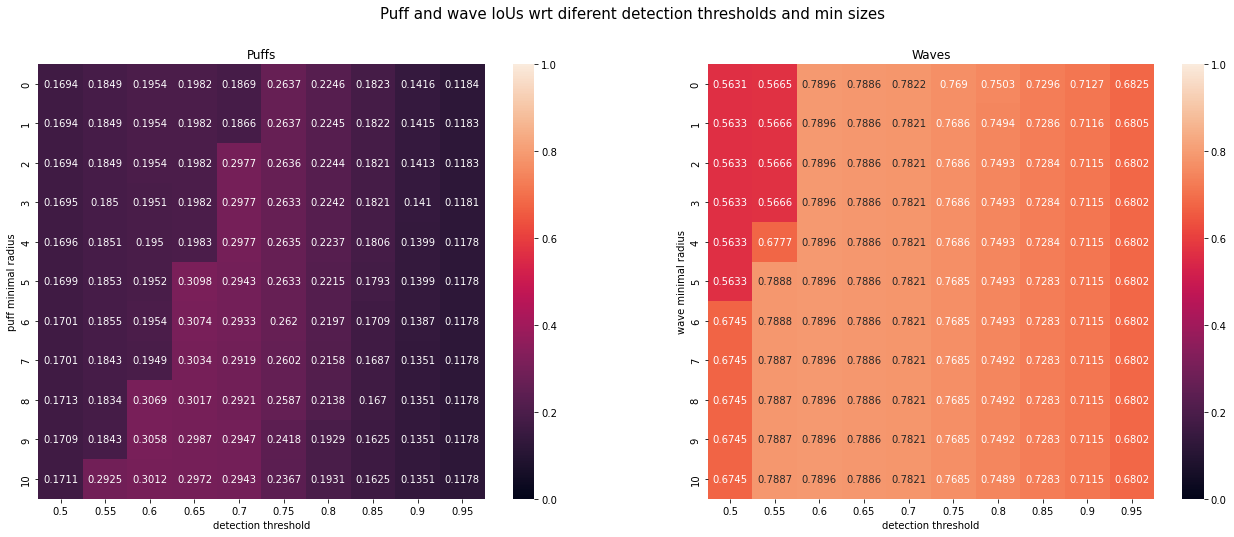

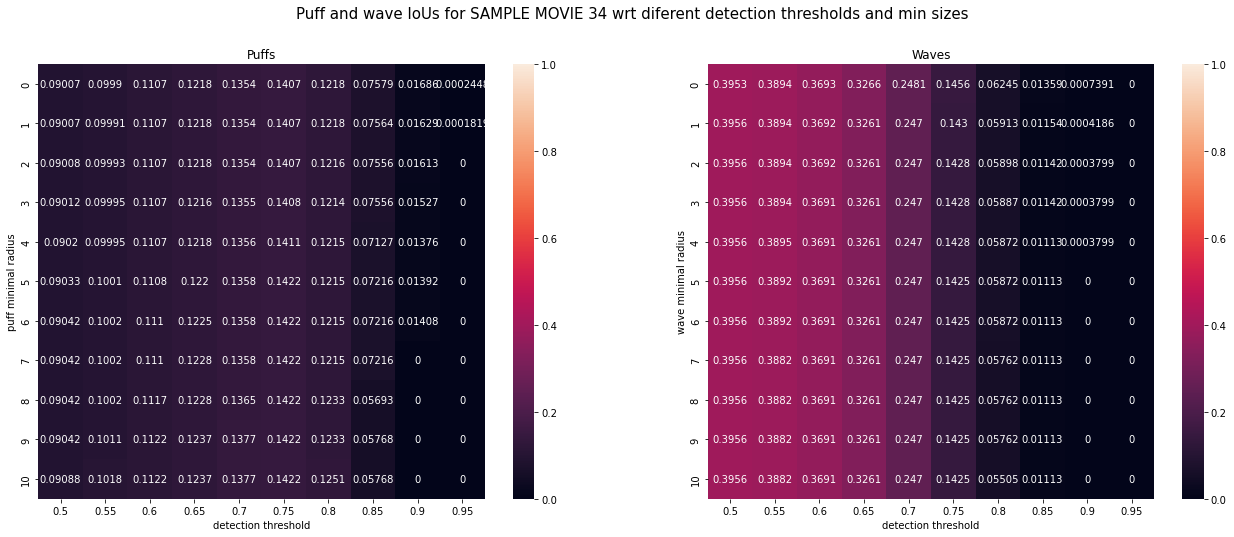

In [25]:
plt.figure(figsize=(22,8))
plt.suptitle(f"Puff and wave IoUs wrt diferent detection thresholds and min sizes", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Puffs")
sns.heatmap(df_puffs, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Waves")
sns.heatmap(df_waves, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("wave minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_all_movies.jpg"))
plt.show()

plt.figure(figsize=(22,8))
plt.suptitle(f"Puff and wave IoUs for SAMPLE MOVIE {movie_id} wrt diferent detection thresholds and min sizes", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Puffs")
sns.heatmap(df_puffs_sample, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Waves")
sns.heatmap(df_waves_sample, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("wave minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_movie_"+movie_id+".jpg"))
plt.show()

**Remark:** Compared to training with standard cross entropy loss, results are much better, but detection threshold need to be lowered.

### Puffs with and with holes removed
Many predicted puff masks have holes inside the events due to the fact that sparks can appear on top of them.
- Is it possible to predict several classes for each single pixel, even if the annotations have a single value?

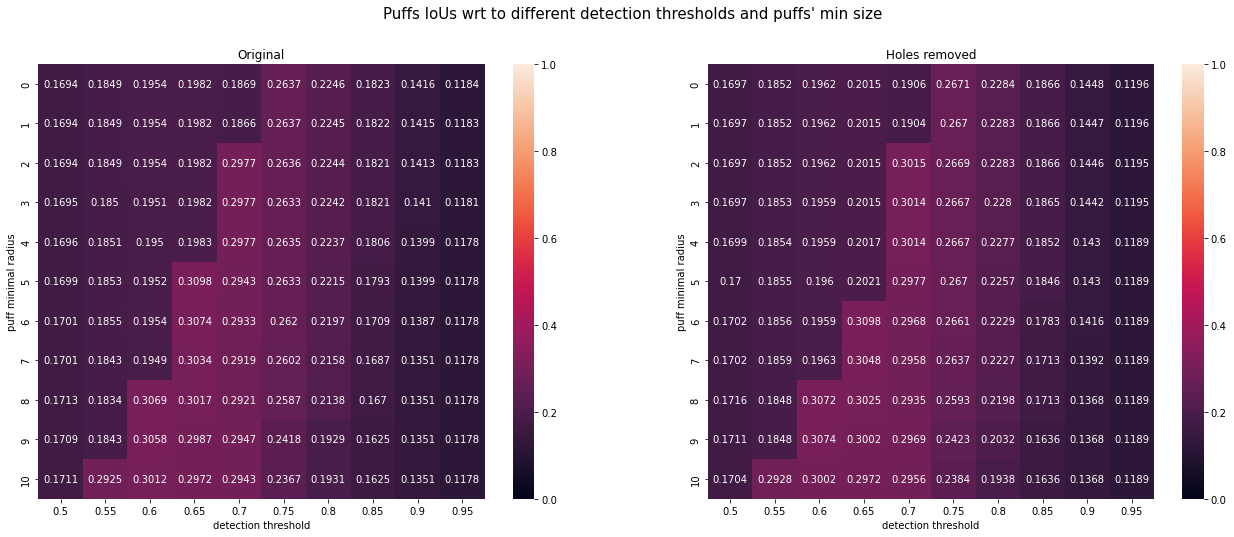

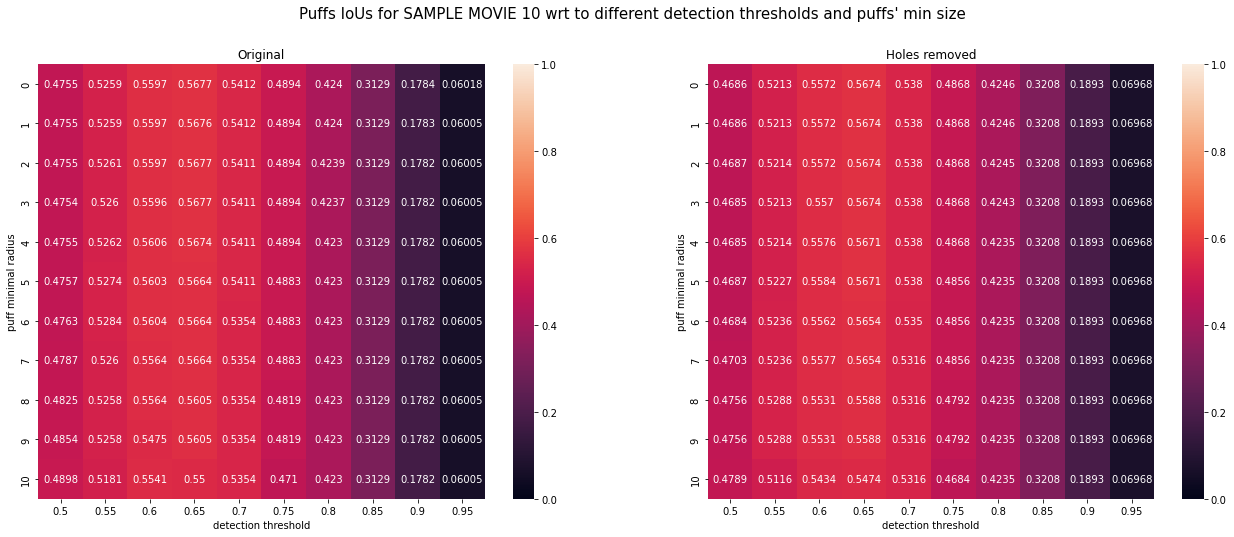

In [11]:
plt.figure(figsize=(22,8))
plt.suptitle(f"Puffs IoUs wrt to different detection thresholds and puffs' min size", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Original")
sns.heatmap(df_puffs, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Holes removed")
sns.heatmap(df_puffs_no_holes, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_puff_holes_vs_no_holes.jpg"))
plt.show()

plt.figure(figsize=(22,8))
plt.suptitle(f"Puffs IoUs for SAMPLE MOVIE {movie_id} wrt to different detection thresholds and puffs' min size", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Original")
sns.heatmap(df_puffs_sample, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Holes removed")
sns.heatmap(df_puffs_no_holes_sample, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_puff_holes_vs_no_holes_movie_"+movie_id+".jpg"))
plt.show()

### Visualise IoU scores for fixed detection threshold and min size wrt to exclusion radius

Fixing `t_detection_waves = 0.6` with `min_radius_waves = 0` and `t_detection_puffs = 0.65` with `min_radius_puffs = 5`

In [12]:
t_waves = '0.6'
min_r_waves = '0'
t_puffs = '0.65'
min_r_puffs = '5'

PUFFS


,0,1,2,3,4,5,6,7,8,9,10
0,0.309779,0.321218,0.325457,0.327136,0.326525,0.324336,0.320929,0.31651,0.311337,0.305336,0.299805


,05,10,15,20,25,32,34,40,45
0,0.148610,0.566367,0.336932,0.180633,0.051124,0.382342,0.121999,0.0,1.0
1,0.137579,0.639602,0.367140,0.195523,0.041148,0.394605,0.115369,0.0,1.0
2,0.106253,0.698254,0.395820,0.199895,0.025405,0.398137,0.105346,0.0,1.0
3,0.075147,0.758333,0.425702,0.192858,0.011594,0.386658,0.093930,0.0,1.0
4,0.046018,0.818170,0.455949,0.173844,0.003258,0.359532,0.081954,0.0,1.0
5,0.023229,0.875573,0.485070,0.147298,0.000413,0.317445,0.069990,0.0,1.0
6,0.008479,0.926489,0.511195,0.118106,0.000000,0.265816,0.058276,0.0,1.0
7,0.001958,0.963926,0.535205,0.089985,0.000000,0.210360,0.047153,0.0,1.0
8,0.000176,0.987822,0.558356,0.063903,0.000000,0.154844,0.036933,0.0,1.0
9,0.000000,0.997135,0.579414,0.041581,0.000000,0.101953,0.027942,0.0,1.0


WAVES


,0,1,2,3,4,5,6,7,8,9,10
0,0.78959,0.80274,0.805084,0.806981,0.808447,0.809643,0.810589,0.811374,0.811936,0.812361,0.812626


,05,10,15,20,25,32,34,40,45
0,1.0,1.0,1.0,1.0,1.0,1.0,0.369290,0.372125,0.364894
1,1.0,1.0,1.0,1.0,1.0,1.0,0.385331,0.487344,0.351983
2,1.0,1.0,1.0,1.0,1.0,1.0,0.400792,0.506094,0.338866
3,1.0,1.0,1.0,1.0,1.0,1.0,0.415034,0.522370,0.325426
4,1.0,1.0,1.0,1.0,1.0,1.0,0.427541,0.536777,0.311704
5,1.0,1.0,1.0,1.0,1.0,1.0,0.439087,0.550017,0.297686
6,1.0,1.0,1.0,1.0,1.0,1.0,0.449619,0.562255,0.283430
7,1.0,1.0,1.0,1.0,1.0,1.0,0.459405,0.573985,0.268974
8,1.0,1.0,1.0,1.0,1.0,1.0,0.468218,0.584980,0.254225
9,1.0,1.0,1.0,1.0,1.0,1.0,0.476146,0.595892,0.239214


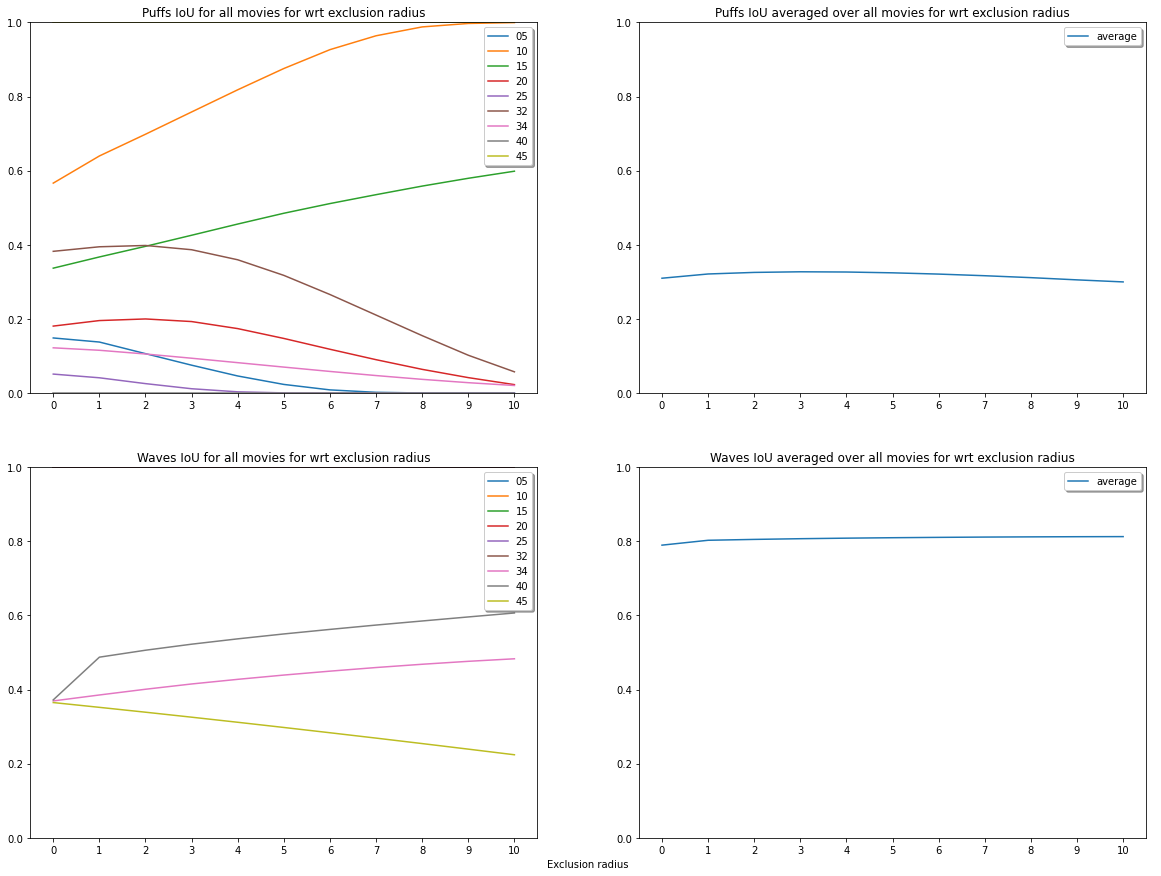

In [19]:
# get dicts and dataframes
dict_puffs_exclusion_r_average_plot = ious_puffs_average[t_puffs][min_r_puffs] # exclusion r

dict_puffs_exclusion_r_plot = ious_puffs[t_puffs][min_r_puffs] # exclusion r x video name
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict))
for exclusion_r, movies_iou in dict_puffs_exclusion_r_plot.items():
    for movie_name, iou in movies_iou.items():
        res[movie_name][exclusion_r] = iou
dict_puffs_exclusion_r_plot = res # video name x exclusion r
            
dict_waves_exclusion_r_average_plot = ious_waves_average[t_waves][min_r_waves] # exclusion r

dict_waves_exclusion_r_plot = ious_waves[t_waves][min_r_waves] # exclusion r x video name
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict))
for exclusion_r, movies_iou in dict_waves_exclusion_r_plot.items():
    for movie_name, iou in movies_iou.items():
        res[movie_name][exclusion_r] = iou
dict_waves_exclusion_r_plot = res # video name x exclusion r

df_puffs_exclusion_r_average_plot = pd.DataFrame.from_dict([dict_puffs_exclusion_r_average_plot])
df_puffs_exclusion_r_average_plot.to_csv(os.path.join(data_folder,"df_puffs_average_iou_exclusion_r_best_t_min_r.csv"))

df_puffs_exclusion_r_plot = pd.DataFrame.from_dict(dict_puffs_exclusion_r_plot)
df_puffs_exclusion_r_plot.to_csv(os.path.join(data_folder,"df_puffs_iou_exclusion_r_best_t_min_r.csv"))

df_waves_exclusion_r_average_plot = pd.DataFrame.from_dict([dict_waves_exclusion_r_average_plot])
df_waves_exclusion_r_average_plot.to_csv(os.path.join(data_folder,"df_waves_average_iou_exclusion_r_best_t_min_r.csv"))

df_waves_exclusion_r_plot = pd.DataFrame.from_dict(dict_waves_exclusion_r_plot)
df_waves_exclusion_r_plot.to_csv(os.path.join(data_folder,"df_waves_iou_exclusion_r_best_t_min_r.csv"))

print("PUFFS")
display(df_puffs_exclusion_r_average_plot)
display(df_puffs_exclusion_r_plot)
print("WAVES")
display(df_waves_exclusion_r_average_plot)
display(df_waves_exclusion_r_plot)

fig, axs = plt.subplots(2, 2, figsize=(20,15))#, sharex=True)
fig.add_subplot(111, frameon=False)

for movie_id in dict_puffs_exclusion_r_plot.keys():
    dict_ious = dict_puffs_exclusion_r_plot[movie_id]
    axs[0,0].plot(dict_ious.keys(), dict_ious.values(), label=movie_id)
           
axs[0,0].set_title('Puffs IoU for all movies for wrt exclusion radius')
axs[0,0].set_ylim([0,1])
axs[0,0].legend(shadow=True, fancybox=True)

axs[0,1].plot(dict_puffs_exclusion_r_average_plot.keys(), dict_puffs_exclusion_r_average_plot.values(), label="average")

axs[0,1].set_title('Puffs IoU averaged over all movies for wrt exclusion radius')
axs[0,1].set_ylim([0,1])
axs[0,1].legend(shadow=True, fancybox=True)

for movie_id in dict_waves_exclusion_r_plot.keys():
    dict_ious = dict_waves_exclusion_r_plot[movie_id]
    axs[1,0].plot(dict_ious.keys(), dict_ious.values(), label=movie_id)
           
axs[1,0].set_title('Waves IoU for all movies for wrt exclusion radius')
axs[1,0].set_ylim([0,1])
axs[1,0].legend(shadow=True, fancybox=True)

axs[1,1].plot(dict_waves_exclusion_r_average_plot.keys(), dict_waves_exclusion_r_average_plot.values(), label="average")

axs[1,1].set_title('Waves IoU averaged over all movies for wrt exclusion radius')
axs[1,1].set_ylim([0,1])
axs[1,1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig(os.path.join(data_folder,"IoU_all_movies_excl_radius.jpg"))

### Remarks:
- would training using e.g. Dice loss make sense? Is it feasible?
- by increasing exclusion radius, some corrected predicted puffs "disappear", making IoU worse
- should apply exlcusion radius to ignored events, too?

# Precision and recall for sparks
- Considering varying minimal size of events and detection threshold
- Tried applying different threshold when spark is detected on top of a puff
- Trying to best summarise spark metrics, but e.g. area under the curve and precision-recall plot are not possible

## Precision and recall computation
- UNet's output processing:
    - threshold is applied to output
    - remove small object with size < 2 * min_radius * n_dims (can be changed) from raw preds
    - apply nonmaxima suppresion to binary mask to extract sparks centres:
        - apply gaussian filter with `sigma=2` to preds
        - define minimal distance between two events as an ellipsoid with axes `min_dist_t x min_dist_xy x min_dist_xy`
        - apply maximum filter to smooth preds
        - find common locations between smooth preds and "maximum filtered version"
    - empty marginal frames (not used by loss function)
    - if using puff preds: spark preds is summed to puff preds in regions where puff preds are between a range of values
- Precision and recall computation:
    - multiply preds by `ignore_mask`
    - compute nonmaxima suppression of annotations
    - get sparks locations in both annotations and predictions
    - compute correspondences between annotations and preds
        - since max distance in time and space between pred and annotation are different, coords are divided by max distance along that dimension, then the max distance allowed on the new coords is 1
        - compute dist between al pairs of preds and annotations
        - solve linear sum assignment problem
        - compute prec and rec with respect to paired events

Because of the processing of preds and annotations before computing prec and rec, their values are not linear with respect to the detection threshold.

In [14]:
data_folder = os.path.join(metrics_folder, "spark_prec_rec")

In [15]:
# Load dicts

# dict containing all prec rec scores for all sparks for all movies
with open(os.path.join(data_folder, "prec_rec_sparks.json"), 'r') as f:
    prec_rec_sparks = json.load(f) # min_r x video_id x detection_t x [prec, rec, tp, tp_fp, tp_fn]
    
# dict containing all prec rec scores for all sparks averaged over all movies
with open(os.path.join(data_folder, "prec_rec_sparks_average.json"), 'r') as f:
    prec_rec_sparks_average = json.load(f) # min_r x detection_t x [prec, rec, tp, tp_fp, tp_fn]
    
    
# dict containing all prec rec scores for all sparks on top of puffs for all movies
with open(os.path.join(data_folder, "prec_rec_sparks_on_puffs.json"), 'r') as f:
    prec_rec_sparks_on_puffs = json.load(f) # t x min_r x exclusion_r x video_id
    
# dict containing all prec rec scores for all sparks on top of puffs averaged over all movies
with open(os.path.join(data_folder, "prec_rec_sparks_on_puffs_average.json"), 'r') as f:
    prec_rec_sparks_on_puffs_average = json.load(f) # t x min_r x exclusion_r

In [26]:
prec_rec_sparks

{'0': {'05': {'0.5': [0.2056451612903226, 0.7285714285714285, 51, 248, 70],
   '0.55': [0.2168141592920354, 0.7, 49, 226, 70],
   '0.6': [0.22439024390243903, 0.6571428571428571, 46, 205, 70],
   '0.65': [0.24210526315789474, 0.6571428571428571, 46, 190, 70],
   '0.7': [0.25766871165644173, 0.6, 42, 163, 70],
   '0.75': [0.2597402597402597, 0.5714285714285714, 40, 154, 70],
   '0.8': [0.2894736842105263, 0.4714285714285714, 33, 114, 70],
   '0.85': [0.4, 0.3142857142857143, 22, 55, 70],
   '0.9': [0.6363636363636364, 0.2, 14, 22, 70],
   '0.95': [1.0, 0.02857142857142857, 2, 2, 70]},
  '10': {'0.5': [0.13821138211382114, 0.85, 17, 123, 20],
   '0.55': [0.16831683168316833, 0.85, 17, 101, 20],
   '0.6': [0.19101123595505617, 0.85, 17, 89, 20],
   '0.65': [0.21621621621621623, 0.8, 16, 74, 20],
   '0.7': [0.24615384615384617, 0.8, 16, 65, 20],
   '0.75': [0.32608695652173914, 0.75, 15, 46, 20],
   '0.8': [0.46875, 0.75, 15, 32, 20],
   '0.85': [0.5454545454545454, 0.3, 6, 11, 20],
   '0.

## Precision and recall using standard threshold

### Get confusion matrix for varying detection threshold and min size

#### Considering average over all movies.

PRECISION


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,0.102949,0.122142,0.146322,0.177732,0.210797,0.266436,0.357143,0.483660,0.677419,1.0
1,0.111502,0.133763,0.158222,0.189579,0.228693,0.280603,0.373377,0.556701,0.722222,1.0
2,0.140878,0.168411,0.193925,0.234104,0.274436,0.335196,0.480663,0.708333,1.000000,1.0


RECALL


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,0.735632,0.716475,0.693487,0.666667,0.628352,0.590038,0.498084,0.283525,0.080460,0.007663
1,0.727969,0.716475,0.681992,0.655172,0.616858,0.570881,0.440613,0.206897,0.049808,0.003831
2,0.701149,0.678161,0.636015,0.620690,0.559387,0.459770,0.333333,0.065134,0.011494,0.000000


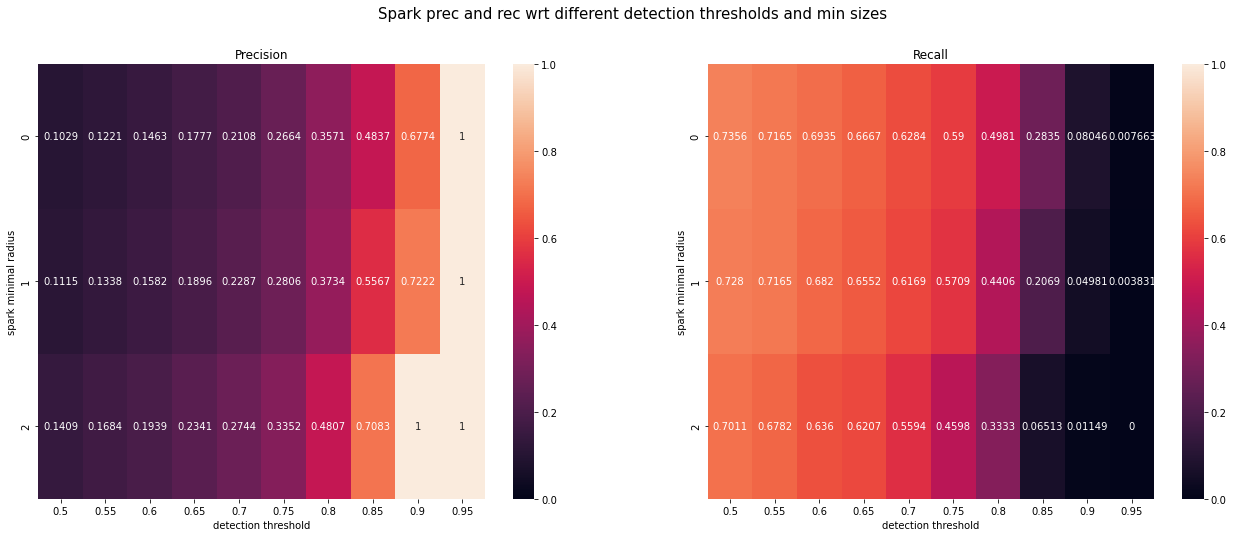

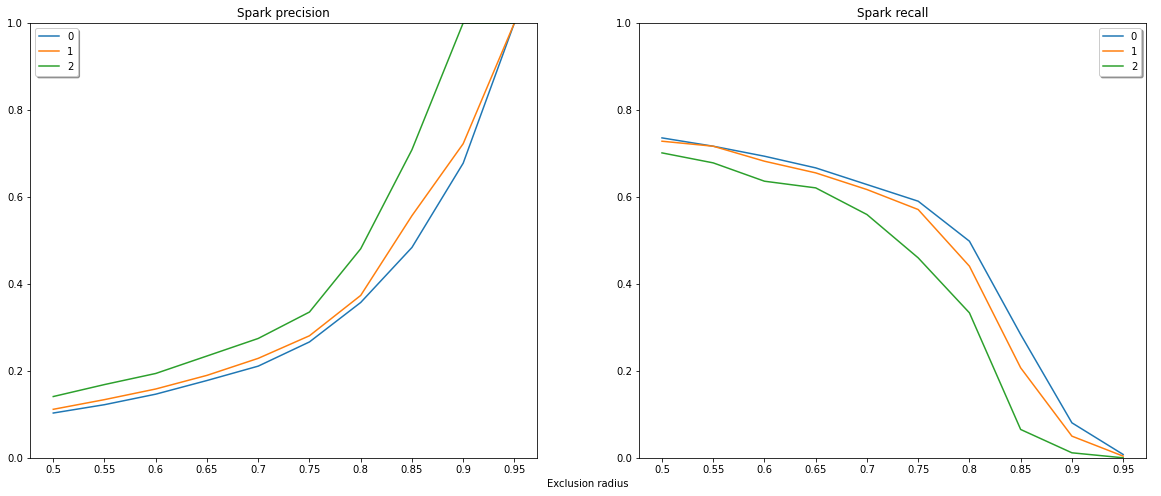

In [16]:
# get dicts for prec and rec
dict_plot_prec = {min_r: {t: metrics[0] for (t, metrics) in t_metrics[0].items()} for (min_r, t_metrics) in prec_rec_sparks_average.items()}
dict_plot_rec = {min_r: {t: metrics[1] for (t, metrics) in t_metrics[0].items()} for (min_r, t_metrics) in prec_rec_sparks_average.items()}

# transpose dicts
dict_cmatrix_prec = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_prec.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_prec[t][min_r] = metrics

dict_cmatrix_rec = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_rec.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_rec[t][min_r] = metrics


# get dataframes
df_prec = pd.DataFrame.from_dict(dict_cmatrix_prec)
df_rec = pd.DataFrame.from_dict(dict_cmatrix_rec)

print("PRECISION")
display(df_prec)
print("RECALL")
display(df_rec)

plt.figure(figsize=(22,8))
plt.suptitle(f"Spark prec and rec wrt different detection thresholds and min sizes", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Precision")
sns.heatmap(df_prec, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Recall")
sns.heatmap(df_rec, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_prec_rec_avg.jpg"))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20,8))#, sharex=True)
fig.add_subplot(111, frameon=False)

for min_r in dict_plot_prec.keys():
    prec = dict_plot_prec[min_r]
    axs[0].plot(prec.keys(), prec.values(), label=min_r)
           
axs[0].set_title('Spark precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for min_r in dict_plot_rec.keys():
    rec = dict_plot_rec[min_r]
    axs[1].plot(rec.keys(), rec.values(), label=min_r)
           
axs[1].set_title('Spark recall')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig(os.path.join(data_folder,"IoU_all_movies_excl_radius.jpg"))

#### Sample movie

In [17]:
movie_id = '05'

# get sample metrics
prec_rec_sparks_sample = {min_r : samples_metrics[movie_id] for (min_r, samples_metrics) in prec_rec_sparks.items()}

# get dicts for prec and rec
dict_plot_prec_sample = {min_r: {t: metrics[0] for (t, metrics) in t_metrics.items()} for (min_r, t_metrics) in prec_rec_sparks_sample.items()}
dict_plot_rec_sample = {min_r: {t: metrics[1] for (t, metrics) in t_metrics.items()} for (min_r, t_metrics) in prec_rec_sparks_sample.items()}

# transpose dicts
dict_cmatrix_prec_sample = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_prec_sample.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_prec_sample[t][min_r] = metrics

dict_cmatrix_rec_sample = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_rec_sample.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_rec_sample[t][min_r] = metrics


# get dataframes
df_prec = pd.DataFrame.from_dict(dict_cmatrix_prec_sample)
df_rec = pd.DataFrame.from_dict(dict_cmatrix_rec_sample)

print("Sample:", movie_id)
print("PRECISION")
display(df_prec)
print("RECALL")
display(df_rec)

Sample: 05
PRECISION


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,0.205645,0.216814,0.224390,0.242105,0.257669,0.259740,0.289474,0.400000,0.636364,1.0
1,0.210084,0.228972,0.234694,0.248619,0.251572,0.267123,0.309278,0.454545,0.714286,1.0
2,0.241206,0.256983,0.246988,0.271523,0.268657,0.303922,0.388889,0.687500,1.000000,1.0


RECALL


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,0.728571,0.700000,0.657143,0.657143,0.600000,0.571429,0.471429,0.314286,0.200000,0.028571
1,0.714286,0.700000,0.657143,0.642857,0.571429,0.557143,0.428571,0.285714,0.142857,0.014286
2,0.685714,0.657143,0.585714,0.585714,0.514286,0.442857,0.300000,0.157143,0.028571,0.000000


## Precision and recall using different threshold on top of puffs

Many sparks are not detected because they are in the middle (i.e. on top) of puffs.
- the probability of the sparks class is lower 
- this results in "holes" in the prediction of puffs

### Get confusion matrix for varying detection threshold and upper detection threshold for puffs

#### Considering average over all movies.

Setting `min_radius = 1` temporarily.

PRECISION


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0.0,0.111502,0.133763,0.158222,0.189579,0.228693,0.280603,0.373377,0.556701,0.722222,1.000000
0.5,0.085474,0.119705,0.141573,0.167276,0.201357,0.234074,0.282222,0.302632,0.222222,0.210526
0.55,0.048126,0.104596,0.137509,0.161431,0.192719,0.221914,0.259635,0.273063,0.188235,0.191919
0.6,0.054466,0.058892,0.124125,0.160609,0.190476,0.219124,0.258491,0.263333,0.188776,0.204918
0.65,0.062152,0.067404,0.072464,0.147304,0.185149,0.215661,0.250441,0.246246,0.189189,0.200000


RECALL


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0.0,0.727969,0.716475,0.681992,0.655172,0.616858,0.570881,0.440613,0.206897,0.049808,0.003831
0.5,0.739464,0.747126,0.724138,0.701149,0.681992,0.605364,0.486590,0.264368,0.114943,0.061303
0.55,0.762452,0.758621,0.731801,0.708812,0.689655,0.613027,0.490421,0.283525,0.122605,0.072797
0.6,0.766284,0.773946,0.747126,0.727969,0.704981,0.632184,0.524904,0.302682,0.141762,0.095785
0.65,0.770115,0.770115,0.747126,0.743295,0.716475,0.643678,0.544061,0.314176,0.160920,0.111111


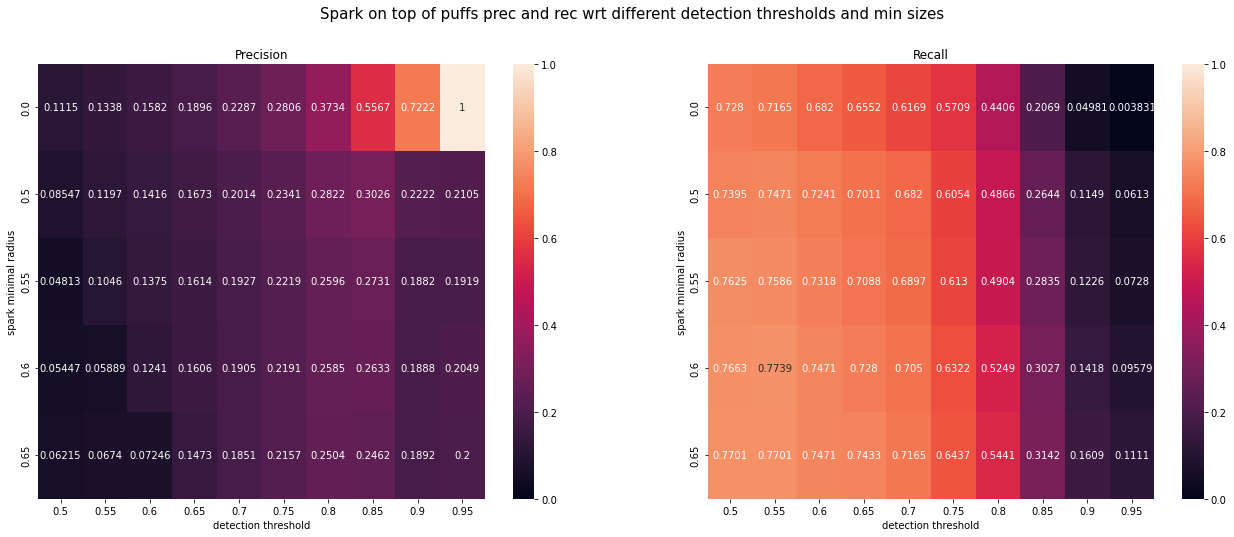

In [18]:
min_r = '1'
# get dicts for prec and rec
dict_plot_prec_puffs = {t_puff: {t_spark: metrics[0] for (t_spark, metrics) in t_metrics[0].items()} for (t_puff, t_metrics) in prec_rec_sparks_on_puffs_average[min_r].items()}
dict_plot_rec_puffs =  {t_puff: {t_spark: metrics[1] for (t_spark, metrics) in t_metrics[0].items()} for (t_puff, t_metrics) in prec_rec_sparks_on_puffs_average[min_r].items()}

# transpose dicts
dict_cmatrix_prec_puffs = defaultdict(lambda: defaultdict(dict))
for t_puff, t_metrics in dict_plot_prec_puffs.items():
    for t_spark, metrics in t_metrics.items():
        dict_cmatrix_prec_puffs[t_spark][t_puff] = metrics

dict_cmatrix_rec_puffs = defaultdict(lambda: defaultdict(dict))
for t_puff, t_metrics in dict_plot_rec_puffs.items():
    for t_spark, metrics in t_metrics.items():
        dict_cmatrix_rec_puffs[t_spark][t_puff] = metrics


# get dataframes
df_prec_puffs = pd.DataFrame.from_dict(dict_cmatrix_prec_puffs)
df_rec_puffs = pd.DataFrame.from_dict(dict_cmatrix_rec_puffs)

print("PRECISION")
display(df_prec_puffs)
print("RECALL")
display(df_rec_puffs)

plt.figure(figsize=(22,8))
plt.suptitle(f"Spark on top of puffs prec and rec wrt different detection thresholds and min sizes", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Precision")
sns.heatmap(df_prec_puffs, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Recall")
sns.heatmap(df_rec_puffs, annot=True, fmt='.4g', vmin=0, vmax=1)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_prec_rec_avg_puffs.jpg"))
plt.show()

Remark: many "false positive" are real sparks that haven't been annotated (**see movie with coloured sparks**)

# Other types of evaluation...
- quantitative evaluation of the method is not very representative of the quality of the predictions
- sometimes "wrongly" predicted events are judged correct by experts because of the high incertitude of the data
- a lot of the "false positive" spark predictions, are actually true events
    - manual threshold has been applied during annotation process, each movie has a different threshold
    - remark: in the UNet output, sparks close to waves are poorly detected (why?)
- since the movies come from different distributions (e.g. different pharmacology), different thresholds would be better suitable for each sample

### Ideas of predictions evalution methods
- creating an interface for experts such that:
    - it presents segmentation with identified events done by UNet and experts annotate them
    - it presents classified segmentation done by UNet and experts decide if events are correct/wrong/grey zone
- Miguel creates first "scarcely" processed segmentation masks for new not annotated samples:
    - experts process and annotate them
    - UNet output is compared with experts' annotated masks

# Manuscript

### Bern Data Science day
- already presented project last year
- new poster focusing on data processing and predictions evaluation?

### Working Group on Cardiac Cellular Electrophysiology Conference
- deadline for abstract on 1st of April

## Other remarks...
- train network to denoise samples? (tried with UNet + MSE)
- temporal reduction improved slightly the results, but I haven't implemented "output expansion" (by number of channels)
- with longer chunks the detection of sparks get worse